In [11]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
from mesa.batchrunner import batch_run

import numpy as np
import pandas as pd

%matplotlib inline

import matplotlib.pyplot as plt

In [3]:
class MoneyAgent(Agent):
    def __init__(self, id, model):
        super().__init__(id, model)
        self.wealth = 1

    def move(self):
        possible_cells = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False
        )
        new_position = self.random.choice(possible_cells)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other_agent = self.random.choice(cellmates)
            other_agent.wealth += 1
            self.wealth -= 1

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()

In [4]:
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum(xi * (N - i) for i, xi in enumerate(x)) / (N * sum(x))
    return (1 + (1 / N) - 2 * B)

In [5]:
class MoneyModel(Model):
    def __init__ (self, num_agents, width, height):
        self.num_agents = num_agents
        self.schedule = RandomActivation(self)
        self.grid = MultiGrid(width, height, True)
        self.datacollector = DataCollector(
            model_reporters = {"Gini": compute_gini},
            agent_reporters = {"Wealth": "wealth"}
        )

        for i in range(num_agents):
            agent = MoneyAgent(i, self)
            self.schedule.add(agent)

            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(agent, (x,y))

    def step(self):
        self.schedule.step()
        self.datacollector.collect(self)

(array([23., 15.,  0.,  5.,  0.,  5.,  1.,  0.,  0.,  1.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

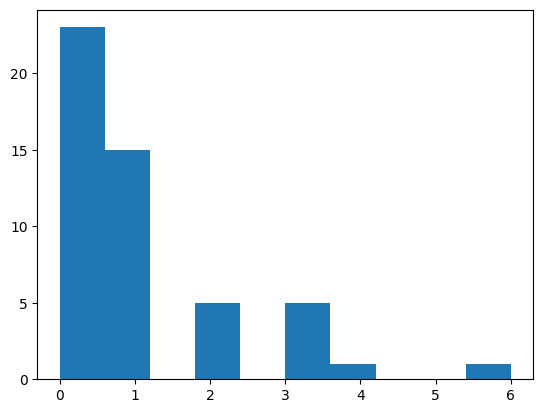

In [6]:
NUM_AGENTS = 50
WIDTH = 10
HEIGHT = 10
STEPS = 100

model = MoneyModel(NUM_AGENTS, WIDTH, HEIGHT)
for i in range(STEPS):
    model.step()

agent_wealth = [agent.wealth for agent in model.schedule.agents]
plt.hist(agent_wealth)

(array([23., 15.,  0.,  5.,  0.,  5.,  1.,  0.,  0.,  1.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

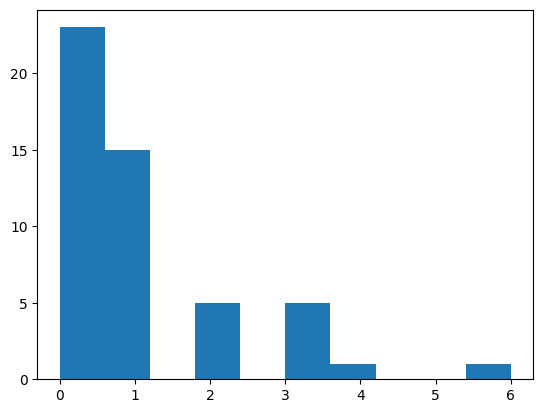

In [7]:
agent_wealth = [agent.wealth for agent in model.schedule.agents]
plt.hist(agent_wealth)

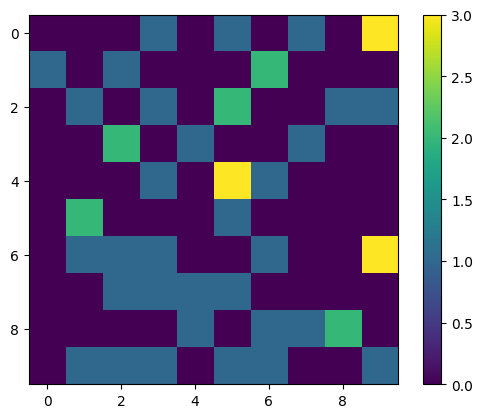

In [8]:
agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell in model.grid.coord_iter():
    (cell_content, (x, y)) = cell
    agent_counts[x][y] = len(cell_content)

plt.imshow(agent_counts, interpolation='nearest')
plt.colorbar()

<Axes: >

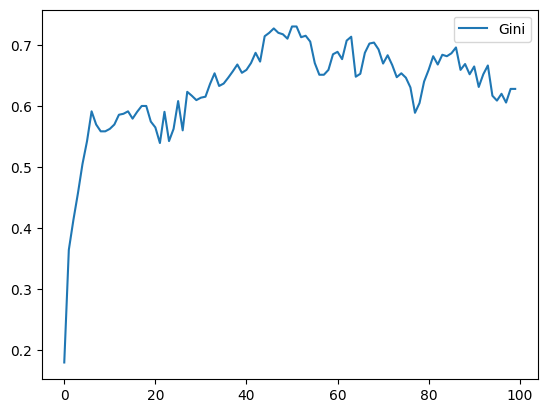

In [9]:
gini = model.datacollector.get_model_vars_dataframe()
gini.plot()

In [10]:
all_wealth = []
for i in range(100):
    model = MoneyModel(10)
    for j in range(10):
        model.step()

    for agent in model.schedule.agents:
        all_wealth.append(agent.wealth)

TypeError: __init__() missing 2 required positional arguments: 'width' and 'height'

(array([425., 309., 164.,  57.,  35.,  10.]),
 array([0., 1., 2., 3., 4., 5., 6.]),
 <BarContainer object of 6 artists>)

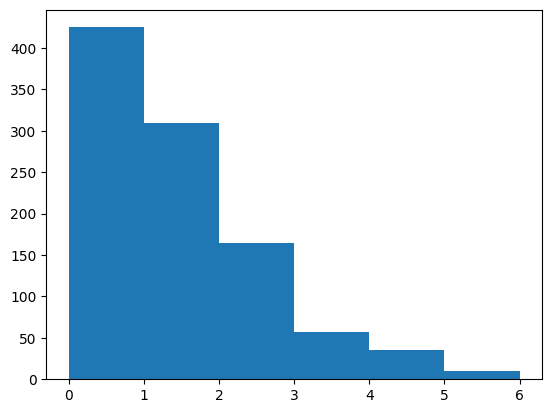

In [ ]:
plt.hist(all_wealth, bins=range(max(all_wealth)+1))

In [12]:
params = {"width": 10, "height": 10, "num_agents": range(10, 500, 10)}

simulations_results = batch_run(MoneyModel, params, iterations=5, max_steps=100)

  0%|          | 0/245 [00:00<?, ?it/s]

AttributeError: 'MoneyModel' object has no attribute 'running'